In [1]:
CLASS_NAMES = ['daisy','dandelion','roses','sunflowers', 'tulips']
CLASS_NAMES

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

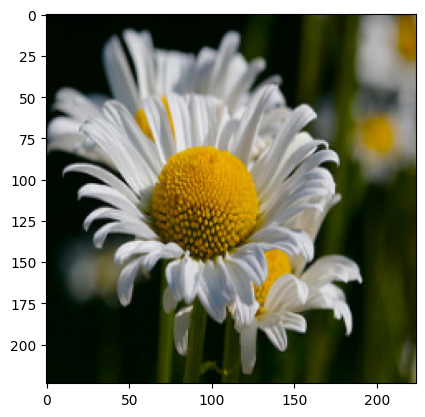

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3 # 흑백은 1, 컬러는 3

def read_and_decode(filename, reshape_dims):
  img = tf.io.read_file(filename)

  # jpeg 포맷을 픽셀 데이터로 변환
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)

  # 0~255 => 0~1 정규화
  img = tf.image.convert_image_dtype(img, tf.float32)

  return tf.image.resize(img, reshape_dims)

def show_image(filename):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  plt.imshow((img.numpy()))

show_image("c:/data/flowers/daisy/754296579_30a9ae018c_n.jpg")

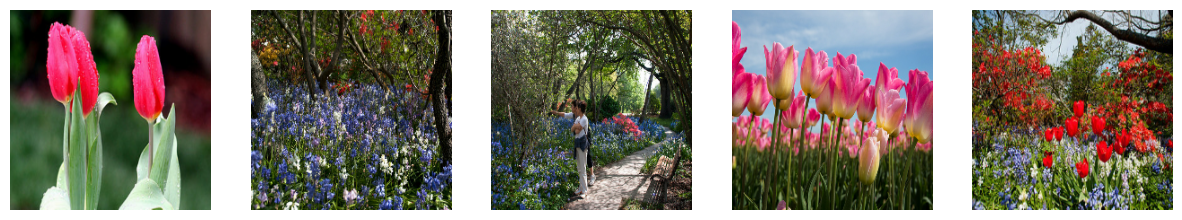

In [3]:
tulips = tf.io.gfile.glob("c:/data/flowers/tulips/*.jpg")

f, ax = plt.subplots(1, 5, figsize=(15,15))

for idx, filename in enumerate(tulips[:5]):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()))
  ax[idx].axis('off')

In [4]:
# label을 추가한 함수

def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))

  return img, label

# Dataset.map(f) : 함수 f를 입력 데이터셋의 각 요소에 적용하여 새로운 데이터셋을 생성
train_dataset = (tf.data.TextLineDataset("c:/data/flowers/train_set.csv").map(decode_csv)).take(800).batch(32)

eval_dataset = (tf.data.TextLineDataset("c:/data/flowers/eval_set.csv").map(decode_csv)).take(200).batch(32)

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = tf.keras.Sequential([
            # Flatten : 다차원을 1차원으로 변환
              Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              Dense(len(CLASS_NAMES), activation='softmax')
])

# from_logits=False 소프트맥스를 사용하지 않는 경우
model.compile(optimizer='adam',
              # CategoricalCrossentropy : 원핫인코딩된 데이터 처리
              # SparseCategoricalCrossentropy : 원핫인코딩되지 않는 데이터 처리
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 5)                 752645    
                                                                 
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=20)

Epoch 1/20
25/25 [==============================] - 1s 54ms/step - loss: 39.9035 - accuracy: 0.2512 - val_loss: 9.3775 - val_accuracy: 0.3600
Epoch 2/20
25/25 [==============================] - 1s 33ms/step - loss: 12.4694 - accuracy: 0.3800 - val_loss: 10.1563 - val_accuracy: 0.4150
Epoch 3/20
25/25 [==============================] - 1s 36ms/step - loss: 10.3876 - accuracy: 0.4250 - val_loss: 13.3014 - val_accuracy: 0.3650
Epoch 4/20
25/25 [==============================] - 1s 35ms/step - loss: 8.7306 - accuracy: 0.5138 - val_loss: 13.9429 - val_accuracy: 0.4650
Epoch 5/20
25/25 [==============================] - 1s 35ms/step - loss: 12.1332 - accuracy: 0.4575 - val_loss: 10.6846 - val_accuracy: 0.3900
Epoch 6/20
25/25 [==============================] - 1s 36ms/step - loss: 9.0790 - accuracy: 0.5050 - val_loss: 10.9763 - val_accuracy: 0.4000
Epoch 7/20
25/25 [==============================] - 1s 37ms/step - loss: 7.9158 - accuracy: 0.5412 - val_loss: 8.6912 - val_accuracy: 0.4000
Epoc

In [7]:
import matplotlib

matplotlib.rcParams.update({'font.size': 20})

def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        ax[idx].plot(history.history['val_' + metric], ls='dashed')
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

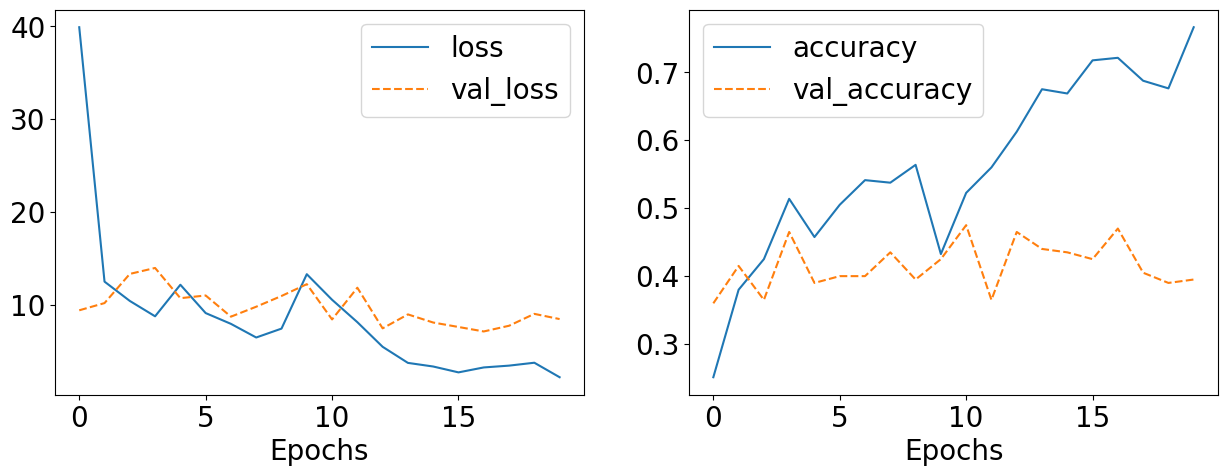

In [8]:
training_plot(['loss', 'accuracy'], history)

In [12]:
def plot_predictions(filename):

  matplotlib.rcParams.update({'font.size': 14})

  f, ax = plt.subplots(3, 5, figsize=(25,15))

  dataset = (tf.data.TextLineDataset(filename).map(decode_csv))

  for idx, (img, label) in enumerate(dataset.skip(50).take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()))
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')



1/1 [==============================] - 0s 13ms/step


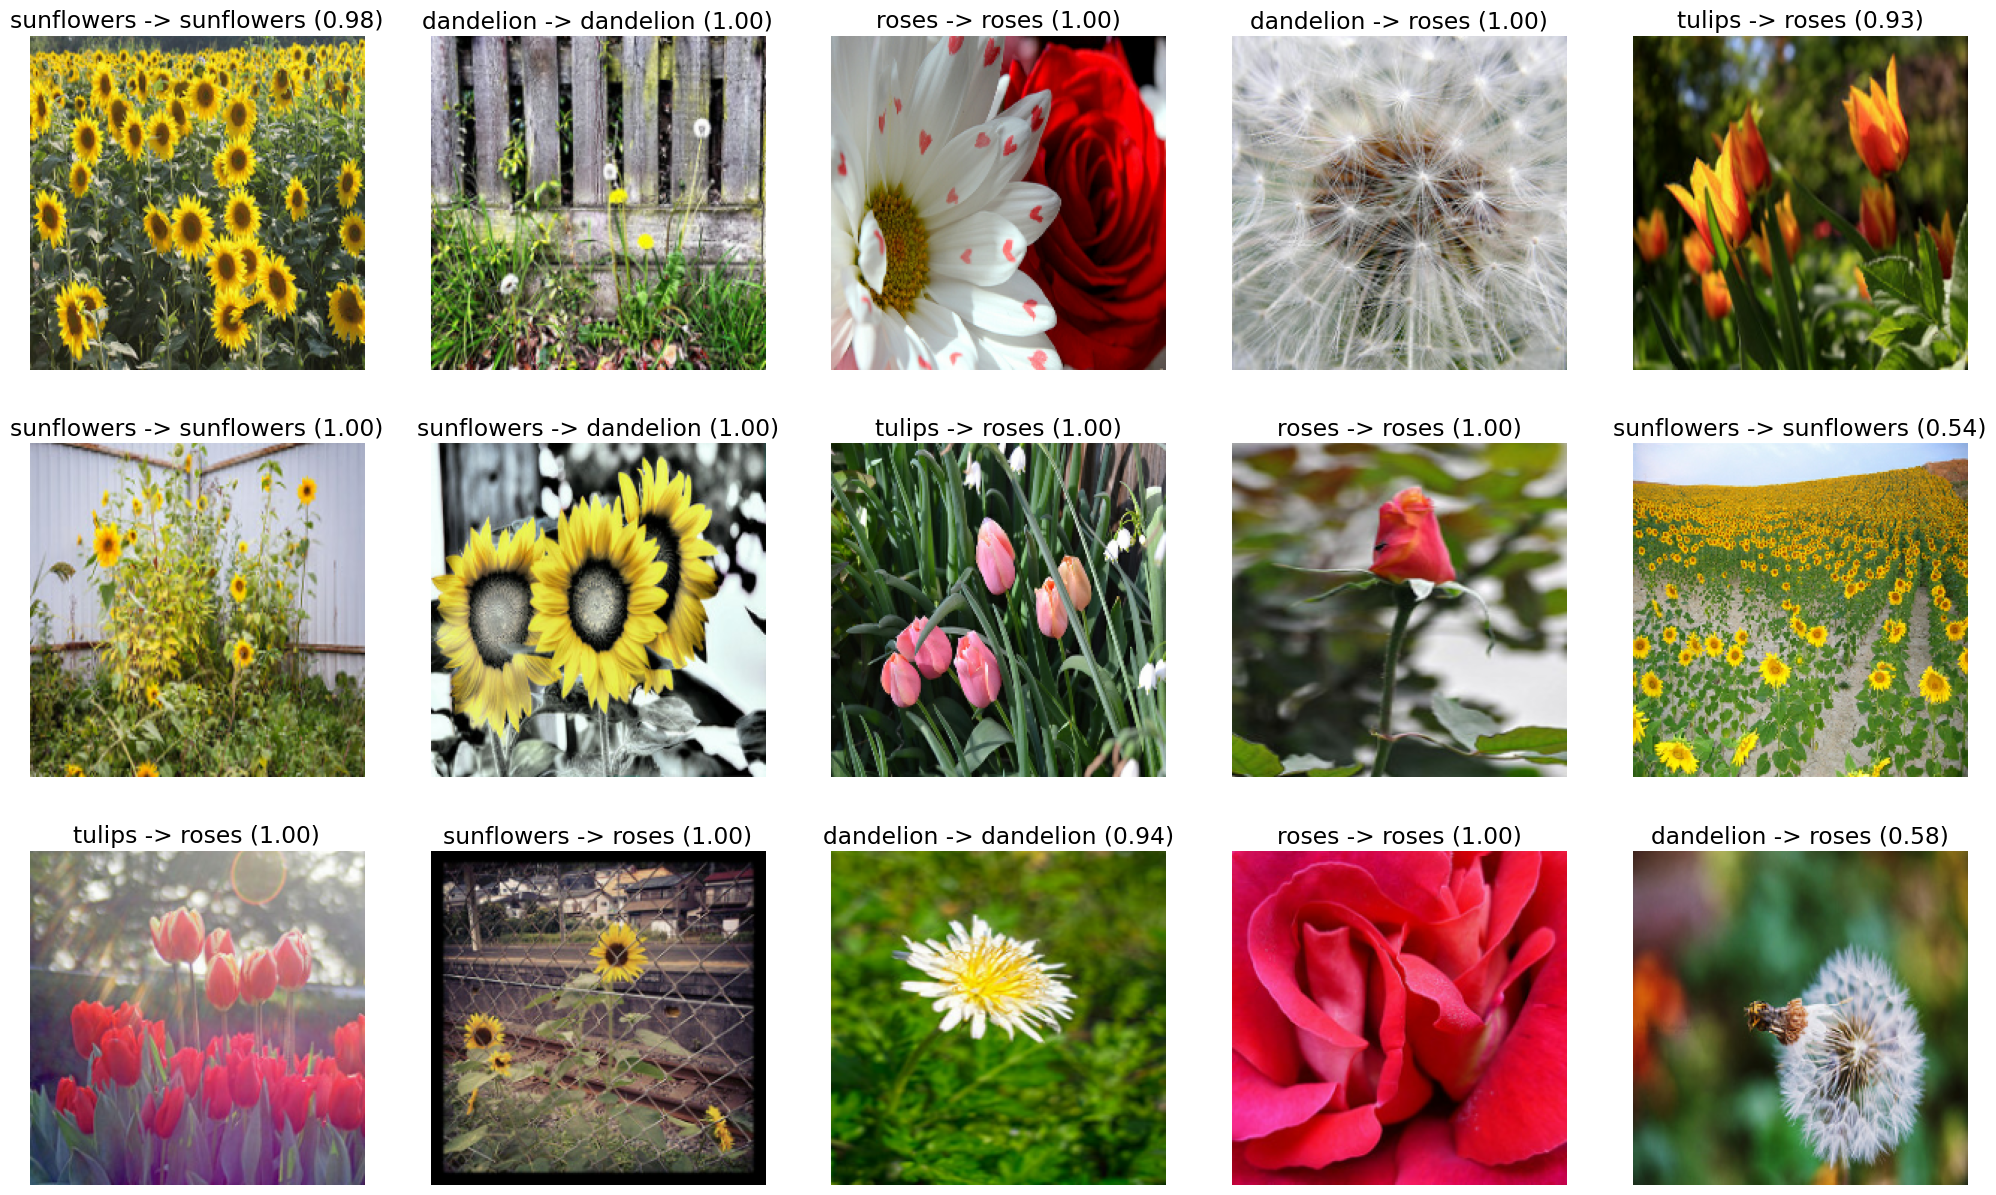

In [13]:
plot_predictions("c:/data/flowers/eval_set.csv")